## 라이브러리 / 기본셋업


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import os

버전 확인

- `python` >= 3.10.12
- `numpy` >= 1.26.0
- `pandas` >= 2.1.1
- `matplotlib` >= 3.8.1
- `seaborn` >= 0.13.0
- `missingno` >= 0.5.2

In [2]:
import sys, matplotlib

print("="*5 ,"나의 라이브러리 버전 확인", "="*5)
print(f"{'python version':15s} <> {sys.version}")
print(f"{'numpy version':15s} <> {np.__version__}")
print(f"{'pandas version':15s} <> {pd.__version__}")
print(f"{'matplotlib version':15s} <> {matplotlib.__version__}")
print(f"{'seaborn version':15s} <> {sns.__version__}")
print(f"{'missingno version':15s} <> {msno.__version__}")

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
numpy version   <> 1.26.3
pandas version  <> 2.1.4
matplotlib version <> 3.8.2
seaborn version <> 0.13.1
missingno version <> 0.5.2


# 데이터셋

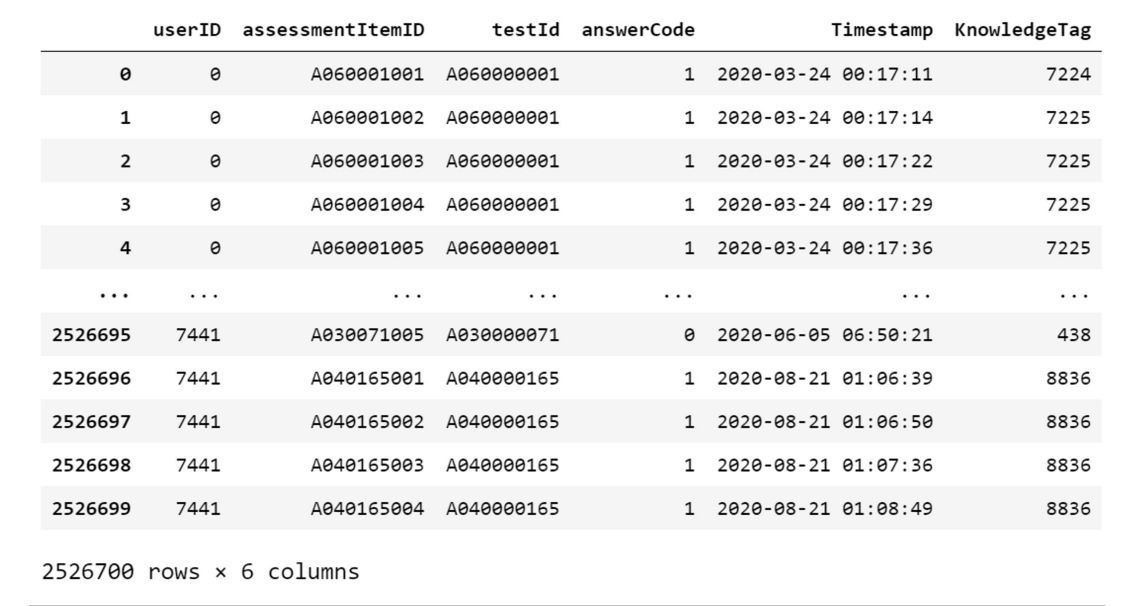

**userID**

총 7,442명의 고유한 사용자 존재

**assessmentItemID**

총 9,454개의 고유한 문항

**testId**

총 1,537개의 고유한 시험지

**answerCode**

사용자가 문항을 맞았는지 여부를 담은 이진 데이터

**Timestamp**

사용자가 Interaction을 시작한 시간 정보

**KnowledgeTag**

총 912개의 고유 태그


In [3]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

# Data load
data_path = "/data/ephemeral/home/level2-dkt-recsys-06/data/"

train = pd.read_csv(data_path + 'train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test = pd.read_csv(data_path + 'test_data.csv', dtype=dtype, parse_dates=['Timestamp'])

CPU times: user 3.31 s, sys: 382 ms, total: 3.69 s
Wall time: 3.69 s


In [4]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [5]:
test.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


In [6]:
# merge data
train = pd.concat([train, test], axis=0)
train = train.sort_values(by=["userID", "Timestamp"]).reset_index(drop=True)

# 정답률에 평균을 사용할 예정이기에 -1인 answer code는 0.5로 변환, 추후에 다시 복구할 예정
train['answerCode'] = train['answerCode'].apply(lambda x: 0.5 if x == -1 else x)

# 자료형 변환
데이터 크기가 커지는 것을 방지하기 위하여 중복된 정보를 제거하였다.

## 1.'assessmentItemID' 변환
A 제거하고 시험번호 및 문제번호만 남김.

문제 번호 열 새로 생성

In [7]:
def process_assessmentItemID(df):
    df['assessmentItemID'] = df['assessmentItemID'].str[1:]
    df['itemseq'] = df['assessmentItemID'].str[-3:].astype(int)
    return df

train = process_assessmentItemID(train)

## 2.'testId' 변환
열에서 2~ 4과 8~ 10 남김(시험번호)

In [8]:
def process_testId(df):
    df['testId'] = df['testId'].apply(lambda x: x[1:4] + x[7:])
    return df

train = process_testId(train)

## 결과확인

In [9]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,itemseq
0,0,060001001,060001,1.0,2020-03-24 00:17:11,7224,1
1,0,060001002,060001,1.0,2020-03-24 00:17:14,7225,2
2,0,060001003,060001,1.0,2020-03-24 00:17:22,7225,3
3,0,060001004,060001,1.0,2020-03-24 00:17:29,7225,4
4,0,060001005,060001,1.0,2020-03-24 00:17:36,7225,5


# Feature Engineering

**0) 기본**

userID: 총 7,442명의 고유한 사용자 존재

assessmentItemID: 총 9,454개의 고유한 문항

testId: 총 1,537개의 고유한 시험지

answerCode: 사용자가 문항을 맞았는지 여부를 담은 이진 데이터

Timestamp: 사용자가 Interaction을 시작한 시간 정보

KnowledgeTag: 총 912개의 고유 태그


**1) Timestamp 관련**

SolvingTime: 유저가 해당 문제푸는데 걸린 시간

CumulativeTime: 유저가 해당 시험에서 그 문제까지의 누적 시간

Month: 달

DayOfWeek: 요일

TimeOfDay: 시간

WeekOfYear: 해당연도의 몇번째 주


**2) User 관련**

UserAvgSolvingTime: 유저의 평균 문제풀이 소요시간

CumulativeProblemCount: 그동안 몇개의 문제를 풀었는지

problems_last7days: 일주일간 푼 문제 수

problems_last30days: 한달 간 푼 문제 수

PastProblemCount: 해당 문제를 과거에 푼 횟수

CumulativeUserProblemAnswerRate: 처음까지 푼 유저의 누적 문제 정답률

**3) Item 관련**

itemseq: test내 문제 번호

ItemAnswerRate: 문제 정답률

AverageItemSolvingTime_Correct: 해당문제 맞은 사람들 평균 소요시간

AverageItemSolvingTime_Incorrect: 해당문제 틀린 사람들 평균 소요시간

AverageItemSolvingTime: 해당문제 평균 소요시간
Difference_SolvingTime_AvgItemSolvingTime: 해당문제 유저 소요시간과 평균 소요시간과의 차이

**4) Tag 관련**

TagAnswerRate: 태그 정답률

CumulativeUserTagAverageAnswerRate: 유저 Tag 기준 과거 정답률

CumulativeUserTagExponentialAverage: 유저 Tag 기준 과거 정답률 지수평균

UserCumulativeTagCount: 유저 태그당 푼 누적 문제 수

UserRecentTagAnswer: 해당 태그의 가장 최근 정답여부

**5) Test 관련**

PreviousProblemAnswer: 같은 테스트 바로 이전 문제 정답 여부

TestAnswerRate: 테스트 전체 정답률

**결측치**

SolvingTime: 해당 시험의 평균으로 대체

CumulativeTime: 이하 동문

**범주화**

categorize_solvingTime: 10개로 범주화

categorize_ProblemAnswerRate: 7개로 범주화(난이도)

categorize_TagAnswerRate: 7개로 범주화(난이도)

categorize_TestAnswerRate: 5개로 범주화(정답률)

categorize_CumulativeUserProblemAnswerRate: 5개로 범주화(정답률)

categorize_CumulativeUserTagAverageAnswerRate: 5개로 범주화(정답률)

categorize_CumulativeUserTagExponentialAverage: 5개로 범주화(정답률)

# 1) Timestamp 관련
SolvingTime: 유저가 해당 문제푸는데 걸린 시간

CumulativeTime: 유저가 해당 시험에서 그 문제까지의 누적 시간

Month: 달

DayOfWeek: 요일

TimeOfDay: 시간

WeekOfYear: 해당연도의 몇번째 주


**결측치**

SolvingTime: 해당 시험의 평균으로 대체

CumulativeTime: 이하 동문

## 1.SolvingTime, CumulativeTime 생성
 1) 해당 문제를 푸는데 걸린 시간(초)

  -만약 10분 이상 푼 문제가 있다면 풀이시간이 10분인 것으로 조정한다.

 2) 해당 시험지 내에서 해당 문제 전까지 누적 풀이 시간(초)

In [10]:
def add_solving_time(df):
    df['NextTimestamp'] = pd.to_datetime(df.groupby(['userID', 'testId'])['Timestamp'].shift(-1))
    df['SolvingTime'] = (df['NextTimestamp'] - df['Timestamp']).dt.total_seconds()
    df.loc[df['SolvingTime'] >= 600, 'SolvingTime'] = 600
    df['CumulativeTime'] = df.groupby(['userID', 'testId'])['SolvingTime'].cumsum()
    df = df.drop(columns=['NextTimestamp'])
    return df

train = add_solving_time(train)
## Issue : 시험지 내 마지막 문제에 Solvingtime 결측

## 시각화를 통한 EDA 결과 확인

/tmp/ipykernel_1352737/3730884394.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_answer_rate = train.loc[time_bin.index].groupby(time_bin)['answerCode'].mean()


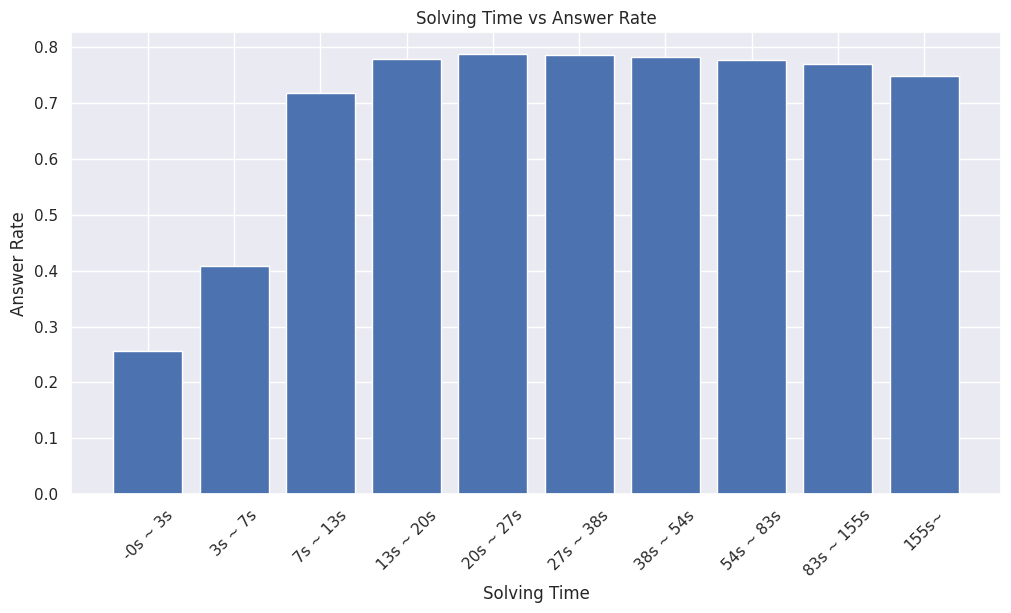

In [11]:
# SolvingTime에 따른 정답률 시각화
df_no_nan = train['SolvingTime'].dropna()
quantiles = df_no_nan.quantile(np.arange(0, 1.1, 0.1)) # 상위 0~10% 풀이시간부터 90~100%까지 10분위로 나눔
time_bin = pd.cut(df_no_nan, bins=quantiles, include_lowest=True)
bin_answer_rate = train.loc[time_bin.index].groupby(time_bin)['answerCode'].mean()
bin_labels = ["{:.0f}s ~ {:.0f}s".format(bin.left, bin.right) for bin in bin_answer_rate.index.categories[:-1]]
bin_labels.append("{:.0f}s~".format(bin_answer_rate.index.categories[-1].left))

plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(len(bin_answer_rate)), height=bin_answer_rate.values, tick_label=bin_labels)
plt.xlabel('Solving Time')
plt.ylabel('Answer Rate')
plt.title('Solving Time vs Answer Rate')
plt.xticks(rotation=45)
plt.show()

결과 해석 : 0~7초 (풀이시간 하위 20%)의 풀이 시간을 가질 경우 오답 비율이 굉장히 높았다. 찍었다는 의미

## SolvingTime, CumulativeTime 결측치

### 1.SolvingTime이 결측치 채우기
SolvingTime이 결측일 때 해당 유저의 해당 시험의 평균 걸린 시간으로 채워준다

In [12]:
# EDA전 SolvingTime 열의 결측치 확인
missing_solving_time = train['SolvingTime'].isnull().sum()

print(f"EDA전 SolvingTime 열의 결측치 개수: {missing_solving_time}")

EDA전 SolvingTime 열의 결측치 개수: 407189


In [13]:
def fill_missing_solving_time(df):
    grouped = df.groupby(['userID', 'testId'])['SolvingTime'].transform('mean')
    df['SolvingTime'] = df['SolvingTime'].fillna(grouped)
    df['SolvingTime'] = df['SolvingTime'].astype(int)

    return df

train = fill_missing_solving_time(train)

In [14]:
# EDA후 SolvingTime 열의 결측치 확인
missing_solving_time = train['SolvingTime'].isnull().sum()

print(f"EDA후 SolvingTime 열의 결측치 개수: {missing_solving_time}")

EDA후 SolvingTime 열의 결측치 개수: 0


### 2.CumulativeTime 결측치
SolvingTime이 결측 채운것을 바탕으로 CumulativeTime 결측치를 채운다.

In [15]:
# EDA전 CumulativeTime 열의 결측치 확인
missing_CumulativeTime = train['CumulativeTime'].isnull().sum()

print(f"EDA전 CumulativeTime 열의 결측치 개수: {missing_CumulativeTime}")

EDA전 CumulativeTime 열의 결측치 개수: 407189


In [16]:
def fill_missing_CumulativeTime(df):
    # 결측값이 있는 행을 선택
    missing_CumulativeTime_rows = df[df['CumulativeTime'].isnull()]

    # 결측값이 있는 행에 대해 루프 수행
    for index, row in missing_CumulativeTime_rows.iterrows():
        # 이전 행의 CumulativeTime가져오기
        prev_cumulative_time = df.at[index - 1, 'CumulativeTime']

        # 현재 행의 solving_time 가져오기
        solving_time = df.at[index, 'SolvingTime']

        # CumulativeTime 갱신
        CumulativeTime = prev_cumulative_time +solving_time

        # SolvingTime 값을 해당 행에 채워 넣기
        df.at[index, 'CumulativeTime'] = CumulativeTime

    df['CumulativeTime'] = df['CumulativeTime'].astype(int)
    return df

train = fill_missing_CumulativeTime(train)

In [17]:
# EDA후 CumulativeTime 열의 결측치 확인
missing_CumulativeTime = train['CumulativeTime'].isnull().sum()

print(f"EDA후 CumulativeTime 열의 결측치 개수: {missing_CumulativeTime}")

EDA후 CumulativeTime 열의 결측치 개수: 0


## 2.Month, DayOfWeek, TimeOfDay, WeekOfYear
문제를 푼 달, 요일, 시간. 해당연도의 몇번째 주

In [18]:
def process_timestamp(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Month'] = df['Timestamp'].dt.month
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
    day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    df['DayOfWeek'] = df['DayOfWeek'].map(day_dict)


    df['TimeOfDay'] = df['Timestamp'].dt.hour

    #'WeekOfYear'열 추가
    df['WeekOfYear'] = df['Timestamp'].dt.isocalendar().week

    return df

train = process_timestamp(train)

## 시각화를 통한 EDA 결과 확인

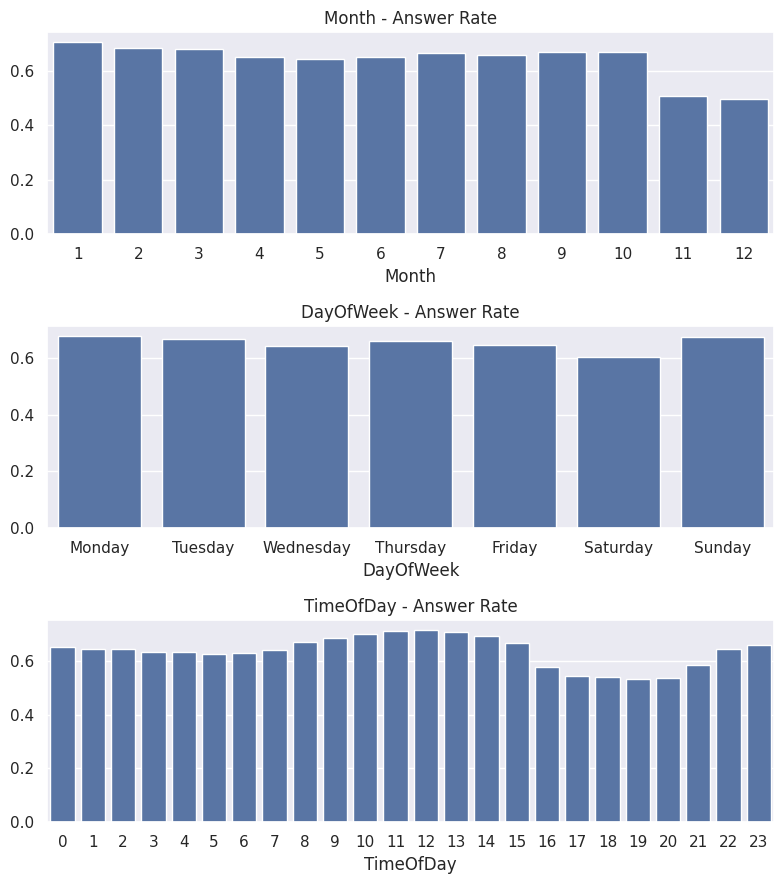

In [19]:
# 각 달에 따른 정답률 계산
month_answer_rate = train.groupby('Month')['answerCode'].mean()

# 각 요일에 따른 정답률 계산
day_answer_rate = train.groupby('DayOfWeek')['answerCode'].mean()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_answer_rate = day_answer_rate.loc[day_order]

# 시간대에 따른 정답률 계산
time_answer_rate = train.groupby('TimeOfDay')['answerCode'].mean()
fig, ax = plt.subplots(3, 1, figsize=(8, 9))

sns.barplot(x=month_answer_rate.index, y=month_answer_rate.values, ax=ax[0])
ax[0].set_title('Month - Answer Rate')

sns.barplot(x=day_answer_rate.index, y=day_answer_rate.values, ax=ax[1])
ax[1].set_title('DayOfWeek - Answer Rate')

sns.barplot(x=time_answer_rate.index, y=time_answer_rate.values, ax=ax[2])
ax[2].set_title('TimeOfDay - Answer Rate')

plt.tight_layout()
plt.show()

결과 해석 : 11, 12월의 정답률이 눈에 띄게 낮음, 밤과 새벽보단 오전, 오후 정답률이 대체로 높음, 요일은 정답률에 영향을 거의 주지 않음

# 2) User 관련
UserAvgSolvingTime: 유저의 평균 문제풀이 소요시간

CumulativeProblemCount: 그동안 몇개의 문제를 풀었는지

problems_last7days: 일주일간 푼 문제 수

problems_last30days: 한달 간 푼 문제 수

PastProblemCount: 해당 문제를 과거에 푼 횟수

CumulativeUserProblemAnswerRate: 처음까지 푼 유저의 누적 문제 정답률

## 1.User 평균 문제풀이 소요시간

In [20]:
def add_user_avg_solving_time(df):
    df['UserAvgSolvingTime'] = df.groupby('userID')['SolvingTime'].transform('mean').astype(int)
    return df

train = add_user_avg_solving_time(train)

## 2.User 누적 문제 풀이수 생성
1) User가 해당 문제 푼 시점으로부터 7일 전까지

2) 30일 전까지

3) 처음부터 푼 누적 문제 수

4) 해당 문제 과거에 푼 횟수: 해당 문제를 과거에 몇번 풀었는지 확인한다.

5) 처음까지 푼 누적 문제 정답률

In [21]:
def add_problem_statistics(df):
    df = df.sort_values(['userID', 'Timestamp'])
    grouped = df.groupby('userID')
    df['CumulativeProblemCount'] = train.groupby('userID').cumcount()

    results = []
    for name, group in grouped:
        group['problems_last7days'] = group.rolling('7D', on='Timestamp')['assessmentItemID'].count() - 1
        group['problems_last30days'] = group.rolling('30D', on='Timestamp')['assessmentItemID'].count() - 1
        results.append(group)

    df = pd.concat(results)
    df['problems_last7days'] = df['problems_last7days'].astype(int)
    df['problems_last30days'] = df['problems_last30days'].astype(int)

    # 해당 문제를 과거에 푼 횟수
    df['PastProblemCount'] = df.groupby(['userID', 'assessmentItemID'])['Timestamp'].cumcount()

    return df

train = add_problem_statistics(train)

## 시각화를 통한 EDA 결과 확인

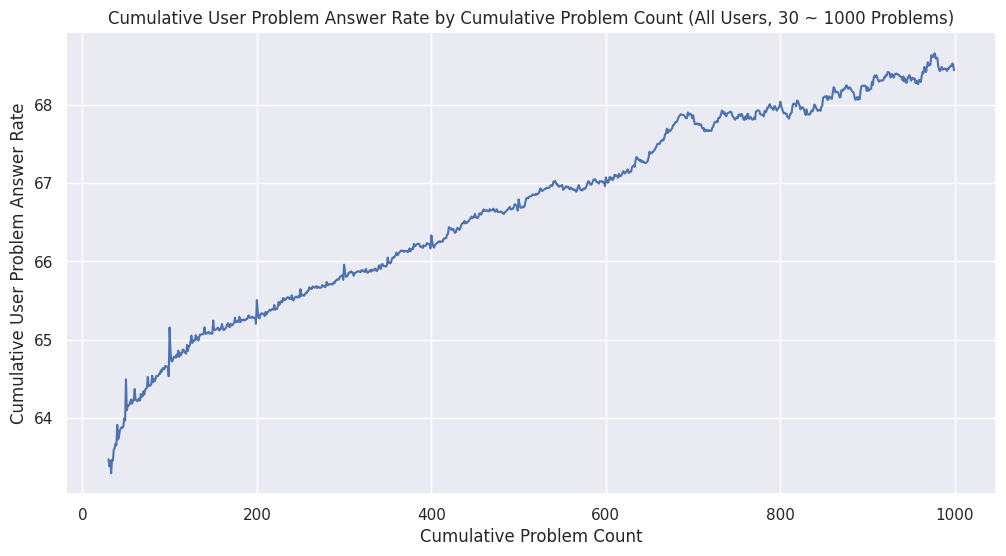

In [22]:
# 누적 풀이 문제수에 따른 정답률 추이 (30문제 이하, 1000문제 이상 제외)
train['CumulativeUserProblemAnswerRate'] = (train.groupby('userID')['answerCode'].transform(lambda x: x.expanding().mean().shift(fill_value=0.5) * 100).astype(int))
selected_df = train[(train['CumulativeProblemCount'] >= 30) & (train['CumulativeProblemCount'] < 1000)]

plt.figure(figsize=(12, 6))
plt.plot(selected_df.groupby('CumulativeProblemCount')['CumulativeUserProblemAnswerRate'].mean())
plt.xlabel('Cumulative Problem Count')
plt.ylabel('Cumulative User Problem Answer Rate')
plt.title('Cumulative User Problem Answer Rate by Cumulative Problem Count (All Users, 30 ~ 1000 Problems)')
plt.show()

결과 해석 : 누적 문제 풀이 숫자가 증가할수록 대체로 정답률이 의미있게 증가함을 확인

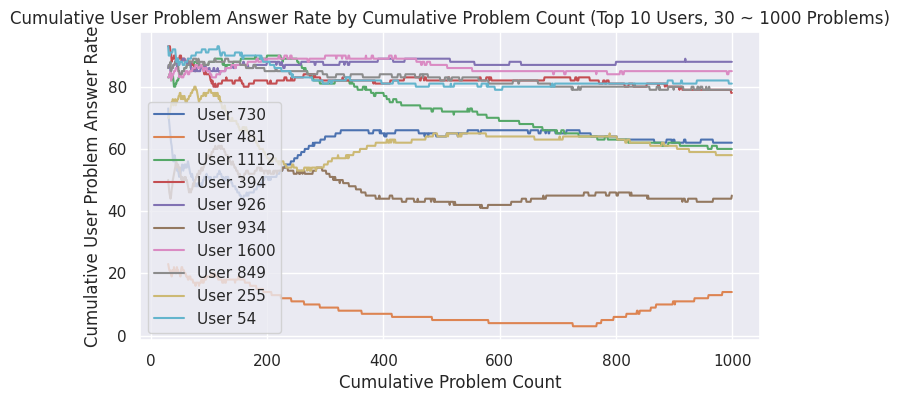

In [23]:
# 문제 풀이 수 상위 10명의 누적 문제풀이 개수별 정답률 추이
top10_users = train['userID'].value_counts().index[:10]

plt.figure(figsize=(8, 4))
for user in top10_users:
    user_df = train[train['userID'] == user]
    selected_user_df = user_df[(user_df['CumulativeProblemCount'] >= 30) & (user_df['CumulativeProblemCount'] < 1000)]
    plt.plot(selected_user_df['CumulativeProblemCount'], selected_user_df['CumulativeUserProblemAnswerRate'], label='User {}'.format(user))

plt.xlabel('Cumulative Problem Count')
plt.ylabel('Cumulative User Problem Answer Rate')
plt.title('Cumulative User Problem Answer Rate by Cumulative Problem Count (Top 10 Users, 30 ~ 1000 Problems)')
plt.legend()
plt.show()

문제 풀이 수 Top 10 유저들의 누적 문제 풀이 별 누적 정답률 그래프. 위의 그래프와 다르게 상승 경향성을 확인하기 힘들다.

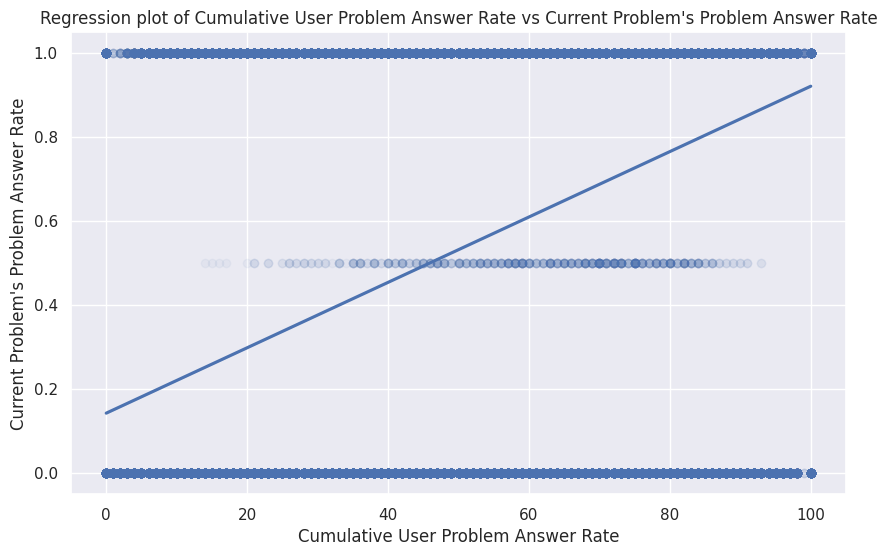

In [24]:
# 이용자의 누적 정답률에 따른 현재 문제의 정답률 회귀선.

plt.figure(figsize=(10, 6))
sns.regplot(x='CumulativeUserProblemAnswerRate', y='answerCode', data=train, scatter_kws={'alpha':0.05})
plt.title('Regression plot of Cumulative User Problem Answer Rate vs Current Problem\'s Problem Answer Rate')
plt.xlabel('Cumulative User Problem Answer Rate')
plt.ylabel('Current Problem\'s Problem Answer Rate')
plt.show()

# 3) Item 관련
itemseq: test내 문제 번호

ItemAnswerRate: 문제 정답률

AverageItemSolvingTime_Correct: 해당문제 맞은 사람들 평균 소요시간

AverageItemSolvingTime_Incorrect: 해당문제 틀린 사람들 평균 소요시간

AverageItemSolvingTime: 해당문제 평균 소요시간

Difference_SolvingTime_AvgItemSolvingTime: 해당문제 유저 소요시간과 평균
소요시간과의 차이


## 1.문제별 정답률

In [25]:
def add_answer_rate_of_item(df):
    df['ItemAnswerRate'] = df['answerCode'].copy()

    # 각 assessmentItemID 별로 정답률 계산하여 새로운 열 추가
    df['ItemAnswerRate'] = (df.groupby('assessmentItemID')['ItemAnswerRate'].transform('mean') * 100).astype(int)

    return df

# 함수 적용
train = add_answer_rate_of_item(train)

## 2.문제별 소요시간


In [26]:
def add_average_solving_time(df):
    df = df.sort_values('assessmentItemID')
    grouped_data = df.groupby('assessmentItemID')

    avg_solving_time_correct_list = []
    avg_solving_time_incorrect_list = []
    avg_problem_solving_time_list=[]

    for name, group in grouped_data:
        # answerCode가 1인 행들의 solving time 평균 계산
        avg_solving_time_correct = group.loc[group['answerCode'] == 1, 'SolvingTime'].mean().astype(int)
        avg_solving_time_correct_list.extend([avg_solving_time_correct] * len(group))

        # answerCode가 0인 행들의 solving time 평균 계산
        avg_solving_time_incorrect = group.loc[group['answerCode'] == 0, 'SolvingTime'].mean().astype(int)
        avg_solving_time_incorrect_list.extend([avg_solving_time_incorrect] * len(group))

        avg_solving_time = group['SolvingTime'].mean().astype(int)
        avg_problem_solving_time_list.extend([avg_solving_time] * len(group))

    df['AverageItemSolvingTime_Correct'] = avg_solving_time_correct_list
    df['AverageItemSolvingTime_Incorrect'] = avg_solving_time_incorrect_list
    df['AverageItemSolvingTime'] = avg_problem_solving_time_list
    df['Difference_SolvingTime_AvgItemSolvingTime'] = (df['SolvingTime'] - df['AverageItemSolvingTime']).astype(int)

    df = df.sort_values(['userID', 'Timestamp'])
    return df

train = add_average_solving_time(train)

# 4) Tag 관련
UserTagAvgSolvingTime: 유저의 태그별 풀이시간 평균

TagAnswerRate: 태그 정답률

CumulativeUserTagAverageAnswerRate: 유저 Tag 기준 과거 정답률

CumulativeUserTagExponentialAverage: 유저 Tag 기준 과거 정답률 지수평균

UserCumulativeTagCount: 유저 태그당 푼 누적 문제 수

UserRecentTagAnswer: 해당 태그의 가장 최근 정답여부


## 1.User 태그별 풀이시간 평균

In [27]:
def add_user_tag_avg_solving_time(df):
    df['UserTagAvgSolvingTime'] = df.groupby(['userID', 'KnowledgeTag'])['SolvingTime'].transform('mean').astype(int)
    return df

train = add_user_tag_avg_solving_time(train)

## 2.태그 정답률

In [28]:
def add_tag_answerRate(df):
    # KnowledgeTag별 정답률 계산
    tag_AnswerRate = df.groupby('KnowledgeTag')['answerCode'].mean()

    df['TagAnswerRate'] = (df['KnowledgeTag'].map(tag_AnswerRate) * 100).astype(int)
    return df

train = add_tag_answerRate(train)

## 3.User의 Tag 기준 과거 정답률

In [29]:
# 1) 단순 평균
def add_cumulative_user_tag_average_answer_rate(df):
    df['CumulativeUserTagAverageAnswerRate'] = (df.groupby(['userID', 'KnowledgeTag'])['answerCode'].transform(lambda x: x.expanding().mean().shift(fill_value=0.5) * 100).astype(int))

    return df

train = add_cumulative_user_tag_average_answer_rate(train)

In [30]:
# 2) 지수 평균
def add_expoenential_user_tag_answer_rate(df):
    df['CumulativeUserTagExponentialAverage'] = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].transform(
        lambda x: x.ewm(alpha=0.3, adjust=False).mean().shift(fill_value=0.5) * 100).astype(int)

    return df

train = add_expoenential_user_tag_answer_rate(train)

In [31]:
# 3) 유저당 태그당 푼 누적 문제 수
def add_user_cumulative_tag_count(df):
    temp = df.groupby(['userID', 'KnowledgeTag']).testId.cumcount()
    df['UserCumulativeTagCount'] = temp
    return df

train = add_user_cumulative_tag_count(train)

## 시각화를 통한 EDA 결과 확인

/tmp/ipykernel_1352737/453188683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.answerCode = temp.answerCode*100


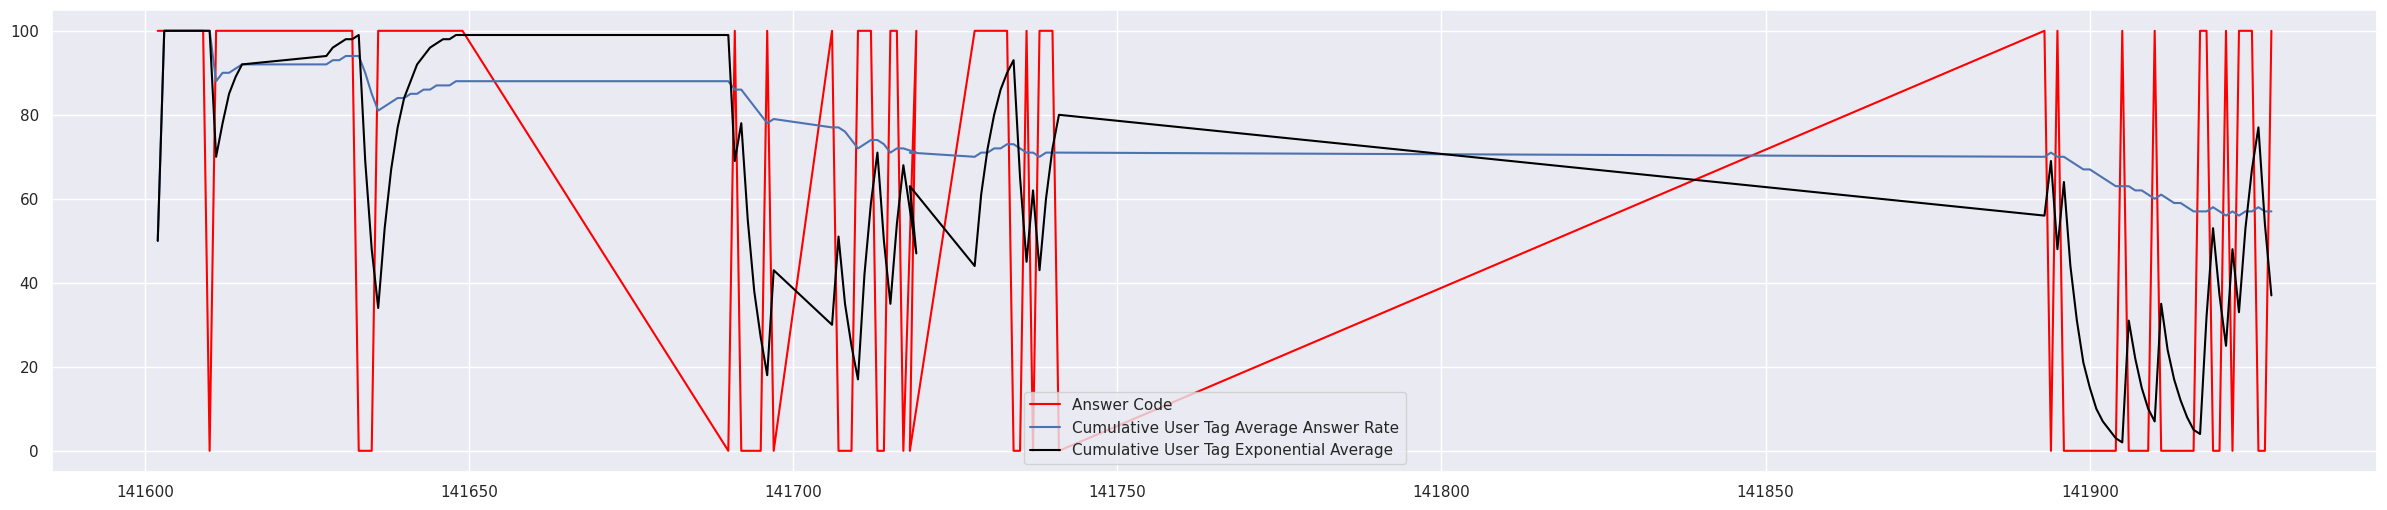

In [32]:
temp = train[train.userID==165]
temp.answerCode = temp.answerCode*100
temp2 = temp[temp.KnowledgeTag==2010][['CumulativeUserTagAverageAnswerRate','CumulativeUserTagExponentialAverage','answerCode','Timestamp']]


plt.figure(figsize=(30,6))

plt.plot(temp2['answerCode'], label='Answer Code', color='red', )
plt.plot(temp2['CumulativeUserTagAverageAnswerRate'], label='Cumulative User Tag Average Answer Rate')
plt.plot(temp2['CumulativeUserTagExponentialAverage'], label='Cumulative User Tag Exponential Average', color='black')

plt.legend()
plt.show()

## 4.User의 Tag 기준 과거 정답 여부
해당 태그의 가장 최근 정답여부를 확인한다




In [33]:
def add_user_recent_tag_answer(df):
    df["UserRecentTagAnswer"] = "U"
    df = df.sort_values(by=["userID", "KnowledgeTag", "Timestamp"]).reset_index(drop=True)

    # 이전에 푼 문제의 정답 여부를 구함
    df["PrevAnswerCode"] = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].shift()

    # 정답 여부에 따라 'Y', 'N'으로 설정
    df.loc[df["PrevAnswerCode"] == 1, 'UserRecentTagAnswer'] = 'Y'
    df.loc[df["PrevAnswerCode"] == 0, 'UserRecentTagAnswer'] = 'N'

    # 이전에 푼 문제가 없는 경우 'U'로 설정
    df.loc[df["PrevAnswerCode"].isna(), 'UserRecentTagAnswer'] = 'U'

    df = df.drop(columns=["PrevAnswerCode"])
    df = df.sort_values(by=["userID", "Timestamp"]).reset_index(drop=True)

    return df

train = add_user_recent_tag_answer(train)

# 5) Test 관련
PreviousProblemAnswer: 같은 테스트 바로 이전 문제 정답 여부

TestAnswerRate: 테스트 전체 정답률

## Test 정답률 생성
1. 같은 테스트 바로 이전 문제 정답 여부: 해당 문제의 테스트의 가장 최근 정답여부를 확인한다.

  "Y": 정답, "N":오답, "U":Unknown 풀어본적 없음

2. Test의 정답률


In [34]:
def add_test_answer_rate_column(df):
    # 1. 같은 테스트 바로 이전 문제 정답 여부
    df['PreviousProblemAnswer'] = df.groupby(['userID', 'testId'])['answerCode'].shift(1)
    df['PreviousProblemAnswer'] = df['PreviousProblemAnswer'].apply(lambda x: 'Y' if x == 1 else ('N' if x == 0 else 'U'))

    # 2.'testId'를 기준으로 'answerCode'의 평균을 계산
    test_avg = df.groupby('testId')['answerCode'].mean()

    df['TestAnswerRate'] = (df['testId'].map(test_avg) * 100).astype(int)
    return df

train = add_test_answer_rate_column(train)

## 결과확인

In [35]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,itemseq,SolvingTime,CumulativeTime,Month,...,AverageItemSolvingTime,Difference_SolvingTime_AvgItemSolvingTime,UserTagAvgSolvingTime,TagAnswerRate,CumulativeUserTagAverageAnswerRate,CumulativeUserTagExponentialAverage,UserCumulativeTagCount,UserRecentTagAnswer,PreviousProblemAnswer,TestAnswerRate
0,0,060001001,060001,1.0,2020-03-24 00:17:11,7224,1,3,3,3,...,13,-10,3,95,50,50,0,U,U,95
1,0,060001002,060001,1.0,2020-03-24 00:17:14,7225,2,8,11,3,...,26,-18,8,91,50,50,0,U,Y,95
2,0,060001003,060001,1.0,2020-03-24 00:17:22,7225,3,7,18,3,...,19,-12,8,91,100,100,1,Y,Y,95
3,0,060001004,060001,1.0,2020-03-24 00:17:29,7225,4,7,25,3,...,18,-11,8,91,100,100,2,Y,Y,95
4,0,060001005,060001,1.0,2020-03-24 00:17:36,7225,5,11,36,3,...,35,-24,8,91,100,100,3,Y,Y,95



# 범주화
categorize_solvingTime: 10개로 범주화

categorize_ProblemAnswerRate: 7개로 범주화(난이도)

categorize_TagAnswerRate: 7개로 범주화(난이도)

categorize_TestAnswerRate: 5개로 범주화(정답률)

categorize_CumulativeUserProblemAnswerRate: 5개로 범주화(정답률)

categorize_CumulativeUserTagAverageAnswerRate: 5개로 범주화(정답률)

categorize_CumulativeUserTagExponentialAverage: 5개로 범주화(정답률)

## 1) SolvingTime 범주화
SolvingTime 열을 10분위로 범주화해서 새로 열 생성

In [36]:
def categorize_solving_time(df):
    # SolvingTime 열을 10분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_solvingTime'] = pd.qcut(df['SolvingTime'], q=10, labels=False)

    return df

train = categorize_solving_time(train)

## 2) 문제 난이도 범주화
범주화해서 새로 열 생성

In [37]:
def categorize_ProblemAnswerRate(df):
    # CorrectnessRate 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_ProblemAnswerRate'] = pd.qcut(df['ItemAnswerRate'], q=7, labels=['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy'])
    return df

train = categorize_ProblemAnswerRate(train)

## 시각화를 통한 EDA 결과 확인

/tmp/ipykernel_1352737/344715273.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  categorize_ProblemAnswerRate = train.groupby('categorize_ProblemAnswerRate')['answerCode'].mean()


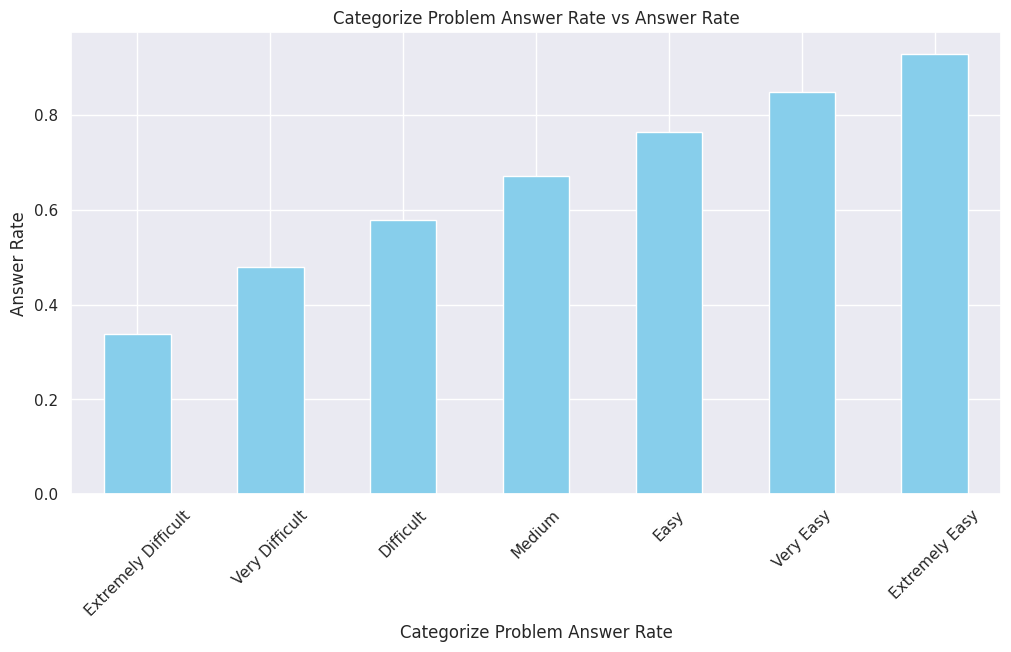

In [38]:
# 범주별 정답률 계산
categorize_ProblemAnswerRate = train.groupby('categorize_ProblemAnswerRate')['answerCode'].mean()
difficulty = ['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy']
categorize_ProblemAnswerRate = categorize_ProblemAnswerRate.loc[difficulty]


# 그래프 시각화
plt.figure(figsize=(12, 6))
categorize_ProblemAnswerRate.plot(kind='bar', color='skyblue')
plt.xlabel('Categorize Problem Answer Rate')
plt.ylabel('Answer Rate')
plt.title('Categorize Problem Answer Rate vs Answer Rate')
plt.xticks(rotation=45)

plt.show()

## 3) Tag 난이도 범주화
범주화해서 새로 열 생성

In [39]:
def categorize_TagCorrectnessRate(df):
    # TagAnswerRate 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_TagAnswerRate'] = pd.qcut(df['TagAnswerRate'], q=7, labels=['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy'])

    return df

train = categorize_TagCorrectnessRate(train)

## 시각화를 통한 EDA 결과 확인

/tmp/ipykernel_1352737/65736694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  categorize_TagAnswerRate = train.groupby('categorize_TagAnswerRate')['answerCode'].mean()


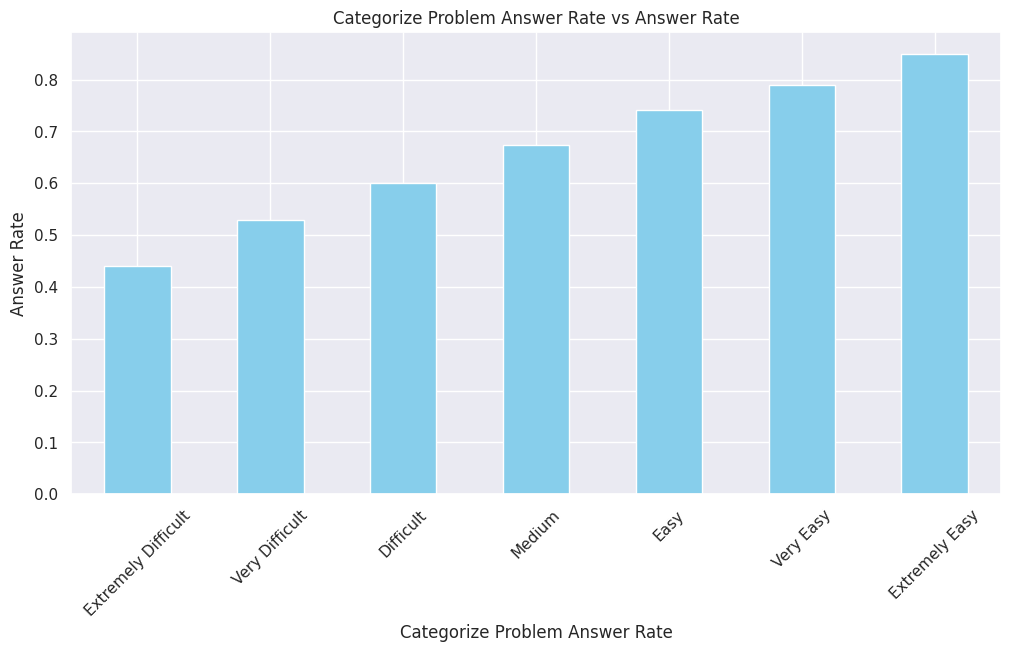

In [40]:
# 범주별 정답률 계산
categorize_TagAnswerRate = train.groupby('categorize_TagAnswerRate')['answerCode'].mean()
difficulty = ['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy']
categorize_TagAnswerRate = categorize_TagAnswerRate.loc[difficulty]


# 그래프 시각화
plt.figure(figsize=(12, 6))
categorize_TagAnswerRate.plot(kind='bar', color='skyblue')
plt.xlabel('Categorize Problem Answer Rate')
plt.ylabel('Answer Rate')
plt.title('Categorize Problem Answer Rate vs Answer Rate')
plt.xticks(rotation=45)

plt.show()

## 4) Test 난이도 범주화
범주화해서 새로 열 생성

In [41]:
def categorize_TestAnswerRate(df):
    # TestAnswerRate 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_TestAnswerRate'] = pd.qcut(df['TestAnswerRate'], q=7, labels=['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy'])
    return df

train = categorize_TestAnswerRate(train)

## 시각화를 통한 EDA 결과 확인


/tmp/ipykernel_1352737/2773136264.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  categorize_TestAnswerRate = train.groupby('categorize_TestAnswerRate')['answerCode'].mean()


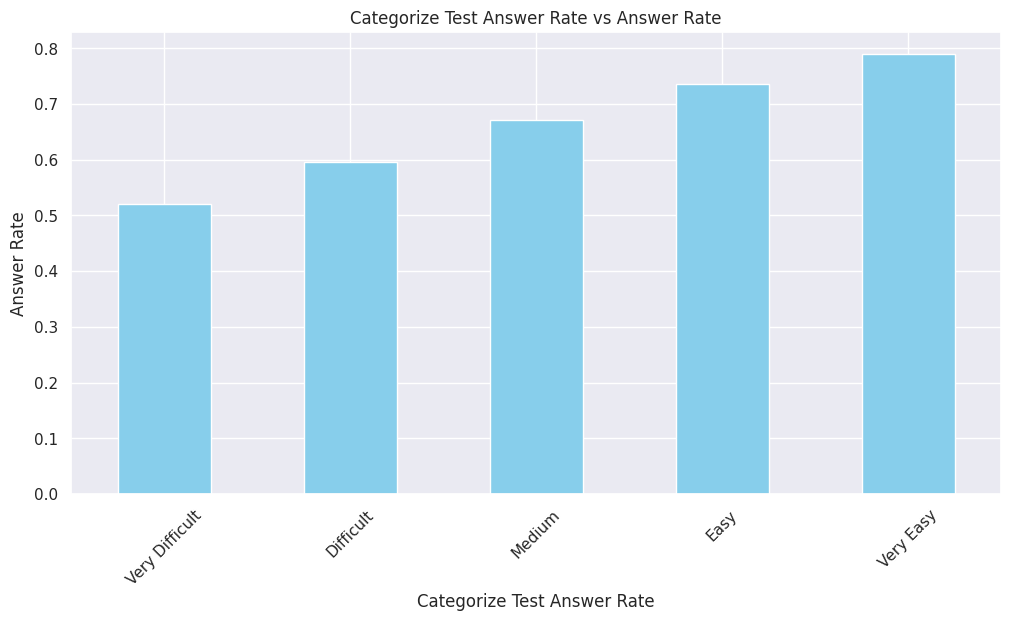

In [42]:
# 범주별 정답률 계산
categorize_TestAnswerRate = train.groupby('categorize_TestAnswerRate')['answerCode'].mean()
difficulty = ['Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy']
categorize_TestAnswerRate = categorize_TestAnswerRate.loc[difficulty]


# 그래프 시각화
plt.figure(figsize=(12, 6))
categorize_TestAnswerRate.plot(kind='bar', color='skyblue')
plt.xlabel('Categorize Test Answer Rate')
plt.ylabel('Answer Rate')
plt.title('Categorize Test Answer Rate vs Answer Rate')
plt.xticks(rotation=45)

plt.show()

## 5) User 전체 정답률 범주화
유저의 누적 정답률을 바탕으로 지식수준 범주화

In [43]:
def categorize_CumulativeUserProblemAnswerRate(df):
    # CumulativeUserProblemAnswerRate 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_CumulativeUserProblemAnswerRate'] = pd.qcut(df['CumulativeUserProblemAnswerRate'], q=5, labels=['Beginner','Elementary_Intermediate', 'Intermediate', 'Intermediate_Advanced','Advanced'])
    return df

train = categorize_CumulativeUserProblemAnswerRate(train)

## 시각화를 통한 EDA 결과 확인


/tmp/ipykernel_1352737/1406371514.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  categorize_CumulativeUserProblemAnswerRate = train.groupby('categorize_CumulativeUserProblemAnswerRate')['answerCode'].mean()


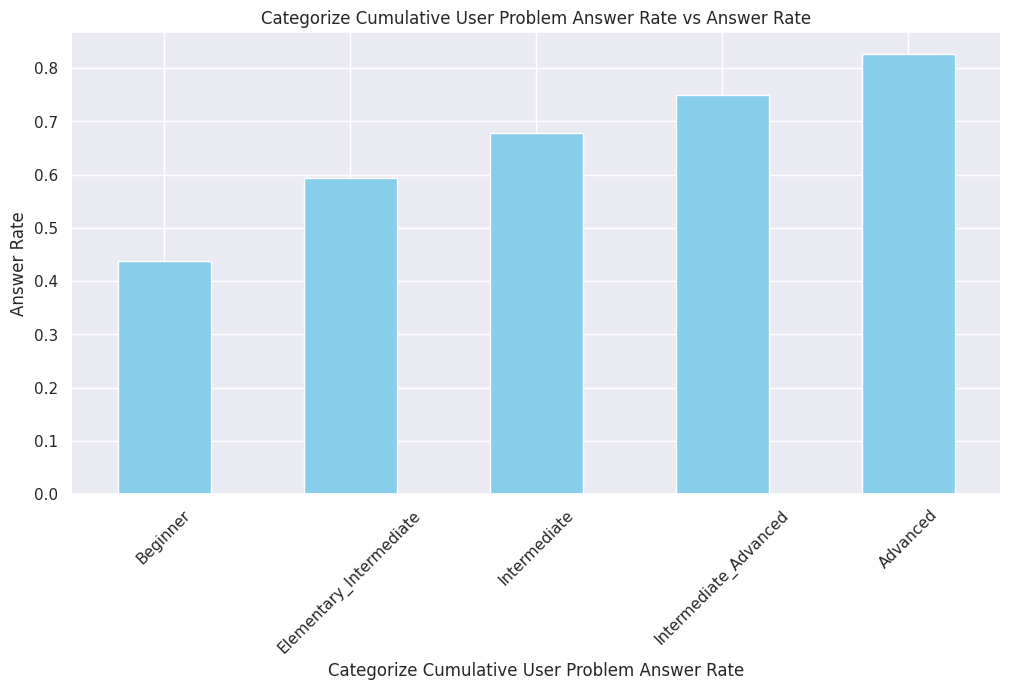

In [44]:
# 범주별 정답률 계산
categorize_CumulativeUserProblemAnswerRate = train.groupby('categorize_CumulativeUserProblemAnswerRate')['answerCode'].mean()
labels = ['Beginner','Elementary_Intermediate', 'Intermediate', 'Intermediate_Advanced','Advanced']
categorize_CumulativeUserProblemAnswerRate = categorize_CumulativeUserProblemAnswerRate.loc[labels]


# 그래프 시각화
plt.figure(figsize=(12, 6))
categorize_CumulativeUserProblemAnswerRate.plot(kind='bar', color='skyblue')
plt.xlabel('Categorize Cumulative User Problem Answer Rate')
plt.ylabel('Answer Rate')
plt.title('Categorize Cumulative User Problem Answer Rate vs Answer Rate')
plt.xticks(rotation=45)

plt.show()

## 6) User의 Tag 기준 정답률 범주화

In [45]:
# 1) 단순 평균
def categorize_cumulative_user_tag_average_answer_rate(df):
    def categorize_answer_rate(value):
        if value <= 20:
            return 'Beginner'
        elif value <= 40:
            return 'Elementary_Intermediate'
        elif value <= 60:
            return 'Intermediate'
        elif value <= 80:
            return 'Intermediate_Advanced'
        else:
            return 'Advanced'

    # 'CumulativeUserTagAverageAnswerRate' 열에 대해 새로운 범주 열을 추가
    df['categorize_CumulativeUserTagAverageAnswerRate'] = df['CumulativeUserTagAverageAnswerRate'].apply(categorize_answer_rate)

    return df

train = categorize_cumulative_user_tag_average_answer_rate(train)

In [46]:
# 2) 지수 평균
def categorize_cumulative_user_tag_exponential_average(df):
    def categorize_answer_rate(value):
        if value <= 20:
            return 'Beginner'
        elif value <= 40:
            return 'Elementary_Intermediate'
        elif value <= 60:
            return 'Intermediate'
        elif value <= 80:
            return 'Intermediate_Advanced'
        else:
            return 'Advanced'

    # 'CumulativeUserTagAverageAnswerRate' 열에 대해 새로운 범주 열을 추가
    df['categorize_CumulativeUserTagExponentialAverage'] = df['CumulativeUserTagExponentialAverage'].apply(categorize_answer_rate)

    return df

train = categorize_cumulative_user_tag_exponential_average(train)

## 시각화를 통한 EDA 결과 확인


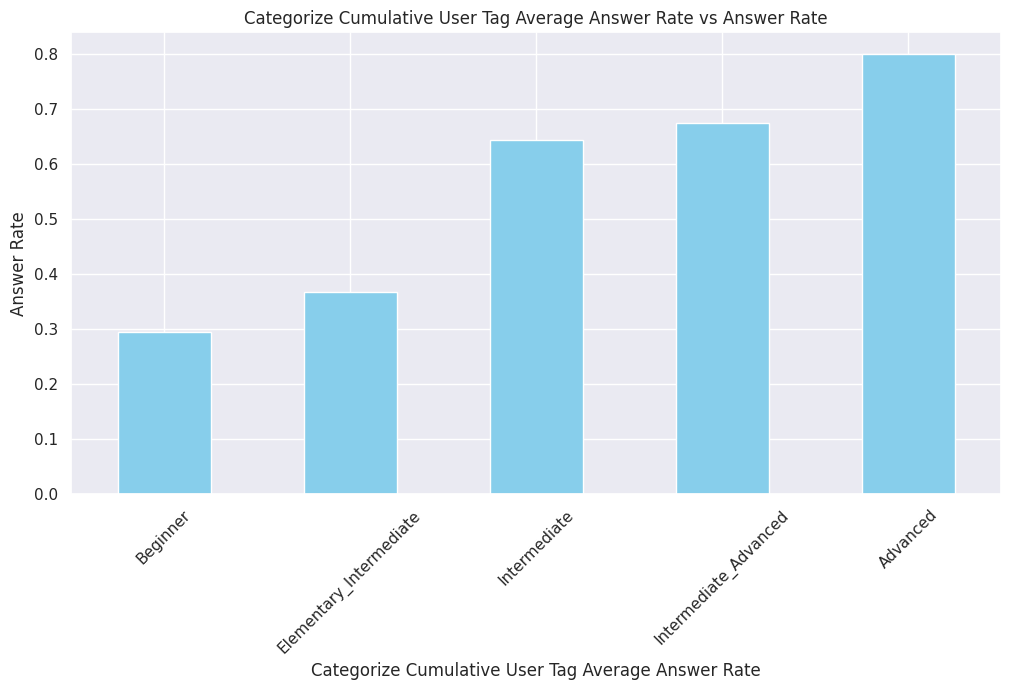

In [47]:
# 1) 단순 평균
categorize_CumulativeUserTagAverageAnswerRate = train.groupby('categorize_CumulativeUserTagAverageAnswerRate')['answerCode'].mean()
labels = ['Beginner','Elementary_Intermediate', 'Intermediate', 'Intermediate_Advanced','Advanced']
categorize_CumulativeUserTagAverageAnswerRate = categorize_CumulativeUserTagAverageAnswerRate.loc[labels]


# 그래프 시각화
plt.figure(figsize=(12, 6))
categorize_CumulativeUserTagAverageAnswerRate.plot(kind='bar', color='skyblue')
plt.xlabel('Categorize Cumulative User Tag Average Answer Rate')
plt.ylabel('Answer Rate')
plt.title('Categorize Cumulative User Tag Average Answer Rate vs Answer Rate')
plt.xticks(rotation=45)

plt.show()

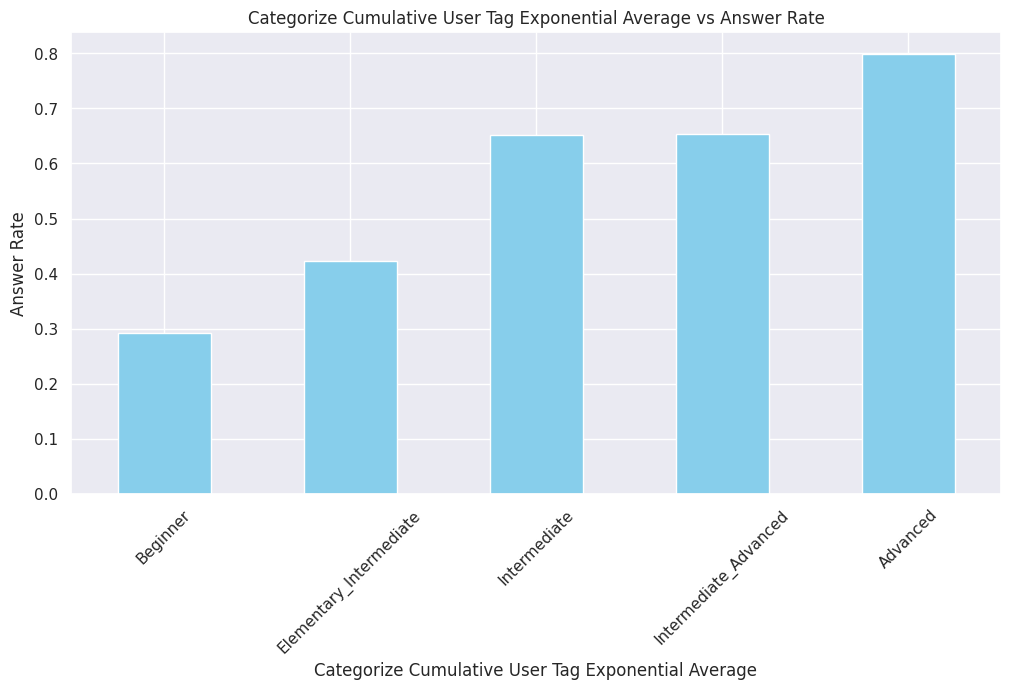

In [48]:
# 2) 지수 평균
categorize_CumulativeUserTagExponentialAverage = train.groupby('categorize_CumulativeUserTagExponentialAverage')['answerCode'].mean()
labels = ['Beginner','Elementary_Intermediate', 'Intermediate', 'Intermediate_Advanced','Advanced']
categorize_CumulativeUserTagExponentialAverage = categorize_CumulativeUserTagExponentialAverage.loc[labels]


# 그래프 시각화
plt.figure(figsize=(12, 6))
categorize_CumulativeUserTagExponentialAverage.plot(kind='bar', color='skyblue')
plt.xlabel('Categorize Cumulative User Tag Exponential Average')
plt.ylabel('Answer Rate')
plt.title('Categorize Cumulative User Tag Exponential Average vs Answer Rate')
plt.xticks(rotation=45)

plt.show()

## 결과확인

In [51]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,itemseq,SolvingTime,CumulativeTime,Month,...,UserRecentTagAnswer,PreviousProblemAnswer,TestAnswerRate,categorize_solvingTime,categorize_ProblemAnswerRate,categorize_TagAnswerRate,categorize_TestAnswerRate,categorize_CumulativeUserProblemAnswerRate,categorize_CumulativeUserTagAverageAnswerRate,categorize_CumulativeUserTagExponentialAverage
0,0,060001001,060001,1,2020-03-24 00:17:11,7224,1,3,3,3,...,U,U,95,0,Extremely Easy,Extremely Easy,Extremely Easy,Beginner,Intermediate,Intermediate
1,0,060001002,060001,1,2020-03-24 00:17:14,7225,2,8,11,3,...,U,Y,95,1,Extremely Easy,Extremely Easy,Extremely Easy,Advanced,Intermediate,Intermediate
2,0,060001003,060001,1,2020-03-24 00:17:22,7225,3,7,18,3,...,Y,Y,95,1,Extremely Easy,Extremely Easy,Extremely Easy,Advanced,Advanced,Advanced
3,0,060001004,060001,1,2020-03-24 00:17:29,7225,4,7,25,3,...,Y,Y,95,1,Extremely Easy,Extremely Easy,Extremely Easy,Advanced,Advanced,Advanced
4,0,060001005,060001,1,2020-03-24 00:17:36,7225,5,11,36,3,...,Y,Y,95,2,Extremely Easy,Extremely Easy,Extremely Easy,Advanced,Advanced,Advanced


# 새로운 CSV 파일 생성

In [50]:
# answerCode 복구
train['answerCode'] = train['answerCode'].apply(lambda x: -1 if x == 0.5 else x)
train['answerCode'] = train['answerCode'].astype(int)

# EDA 파일명
new_csv_name = "FE_v7.csv"
new_csv_path = os.path.join(data_path, new_csv_name)

# 데이터프레임을 CSV 파일로 저장
train.to_csv(new_csv_path, index=False)

print(f"총 {len(train.columns)}개의 Feature가 있습니다.")
print(train.columns)
print(new_csv_name + " has been made")

총 39개의 Feature가 있습니다.
Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'itemseq', 'SolvingTime', 'CumulativeTime', 'Month',
       'DayOfWeek', 'TimeOfDay', 'WeekOfYear', 'UserAvgSolvingTime',
       'CumulativeProblemCount', 'problems_last7days', 'problems_last30days',
       'PastProblemCount', 'CumulativeUserProblemAnswerRate', 'ItemAnswerRate',
       'AverageItemSolvingTime_Correct', 'AverageItemSolvingTime_Incorrect',
       'AverageItemSolvingTime', 'Difference_SolvingTime_AvgItemSolvingTime',
       'UserTagAvgSolvingTime', 'TagAnswerRate',
       'CumulativeUserTagAverageAnswerRate',
       'CumulativeUserTagExponentialAverage', 'UserCumulativeTagCount',
       'UserRecentTagAnswer', 'PreviousProblemAnswer', 'TestAnswerRate',
       'categorize_solvingTime', 'categorize_ProblemAnswerRate',
       'categorize_TagAnswerRate', 'categorize_TestAnswerRate',
       'categorize_CumulativeUserProblemAnswerRate',
       'categorize_Cumula